# Netflix EDA Project

This project will explore the Netflix Titles dataset to uncover insights and trends about the types of content available, country-wise production, year-wise additions, and more.

Both **pandas** and **SQL (SQLite)** are used for data analysis, and visualizations using **Matplotlib** and **Seaborn**.

**Source:** (https://www.kaggle.com/datasets/shivamb/netflix-shows)


## Step 1: Clean the Data

**Set Up:**

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
sns.set_palette("pastel")

**Read the dataset:**

In [2]:
df = pd.read_csv('../data/raw_netflix_titles.csv')

**Check the properties:**

In [3]:
print(df.shape)
df.info()
df.head()
df.tail()
df.dtypes
df.isnull().sum().sort_values(ascending=False)
df.duplicated().sum()
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

(8807, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
show_id: 8807 unique values
type: 2 unique values
title: 8807 unique values
director: 4528 unique values
cast: 7692 unique values
country: 748 unique values
date_added: 1767 unique values
release_year: 74 unique values
rating: 17 unique valu

**Findings:**

Raw netflix titles dataset contains 12 columns and 8807 rows.

Dataset contains 11 object colums and 1 integer column.

Columns director, cast, country, date_added, rating and duration has missing values.

Show_id and title has all unique data so there are no duplicates.

Column durations has a mixed format.

Date_added has string values and should be converted to a datetime object.


**Clean the data:**

In [4]:
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')
df['rating'] = df['rating'].fillna('Unknown')
df['duration'] = df['duration'].fillna('Unknown')

df['date_added'] = pd.to_datetime(
    df['date_added'].astype(str).str.strip(),
    format='mixed',
    errors='coerce'
)

df['duration_int'] = df['duration'].str.extract(r'(\d+)').astype(float)
df['duration_type'] = df['duration'].str.extract(r'([a-zA-Z]+)')

df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

df = df.dropna(subset=['year_added']).copy()
df['year_added'] = df['year_added'].astype(int)

cols_to_clean = ['type', 'rating', 'country', 'listed_in']
for col in cols_to_clean:
    df[col] = df[col].str.strip()

**Save the clean data:**

In [5]:
df.to_csv('../data/cleaned_netflix_titles.csv', index=False)

## Step 2: Create a Database

**Create a DB for data analysis and exploration:**

In [6]:
df = pd.read_csv('../data/cleaned_netflix_titles.csv')
conn = sqlite3.connect('../data/netflix.db')
df.to_sql('netflix', conn, if_exists='replace', index=False)

8797

## Step 3: Explotary Analysis

**3.0: Check the properties of the cleaned data**

In [7]:
df = pd.read_sql('SELECT * FROM netflix', conn)
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8797 entries, 0 to 8796
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   show_id        8797 non-null   object 
 1   type           8797 non-null   object 
 2   title          8797 non-null   object 
 3   director       8797 non-null   object 
 4   cast           8797 non-null   object 
 5   country        8797 non-null   object 
 6   date_added     8797 non-null   object 
 7   release_year   8797 non-null   int64  
 8   rating         8797 non-null   object 
 9   duration       8797 non-null   object 
 10  listed_in      8797 non-null   object 
 11  description    8797 non-null   object 
 12  duration_int   8794 non-null   float64
 13  duration_type  8797 non-null   object 
 14  year_added     8797 non-null   int64  
 15  month_added    8797 non-null   float64
dtypes: float64(2), int64(2), object(12)
memory usage: 1.1+ MB


,release_year,duration_int,year_added,month_added
count,8797.000000,8794.000000,8797.000000,8797.000000
mean,2014.183472,69.920173,2018.871888,6.654996
std,8.822191,50.797005,1.574243,3.436554
min,1925.000000,1.000000,2008.000000,1.000000
25%,2013.000000,2.000000,2018.000000,4.000000
50%,2017.000000,88.000000,2019.000000,7.000000
75%,2019.000000,106.000000,2020.000000,10.000000
max,2021.000000,312.000000,2021.000000,12.000000


**3.1: Movies vs TV Shows**

Analyze the distribution of the content types on Netflix.

**SQL Query:**

In [8]:
query = '''
SELECT type, COUNT(*) as count
FROM netflix
GROUP By type
'''

df_type = pd.read_sql(query, conn)

**Visualization:**

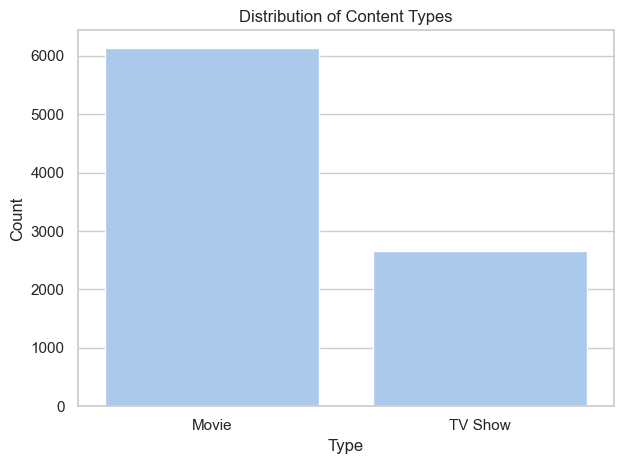

In [9]:
sns.barplot(data=df_type, x='type', y='count')
plt.title('Distribution of Content Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig("../visuals/content_type_distribution.png")
plt.show()

**3.2: The Growth of Netflix Content Over the Years**

Analyze the number of movies and TV series added to Netflix each year.

**SQL Query:**

In [13]:
query = '''
SELECT year_added, COUNT(*) as title_count
FROM netflix
WHERE year_added IS NOT NULL
GROUP BY year_added
ORDER BY year_added
'''

df_growth = pd.read_sql(query, conn)

**Visualization:**

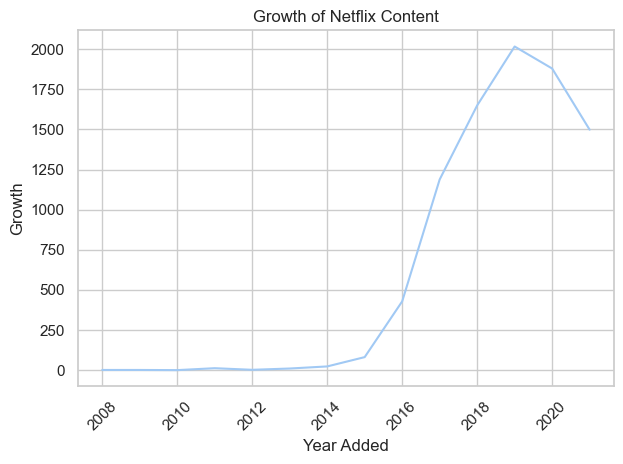

In [15]:
sns.lineplot(data=df_growth, x='year_added', y='title_count')
plt.title('Growth of Netflix Content')
plt.xlabel('Year Added')
plt.ylabel('Growth')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../visuals/content_growth.png")
plt.show()

**3.3: Most Common Genres**

Analyze the data set to find top 10 most common genres on Netflix.

**SQL Query:**

In [16]:
query = ''' 
SELECT show_id, listed_in
FROM netflix
'''

df_genres = pd.read_sql(query, conn)

**Clean and explode the genres:**

In [23]:
df_genres = df.copy()
df_genres['genre'] = df_genres['listed_in'].str.split(',')
df_genres = df_genres.explode('genre')
df_genres['genre'] = df_genres['genre'].str.strip()

genre_counts = df_genres['genre'].value_counts().head(10)

top_genres = genre_counts.reset_index()
top_genres.columns = ['genre', 'count']


**Visualization:**

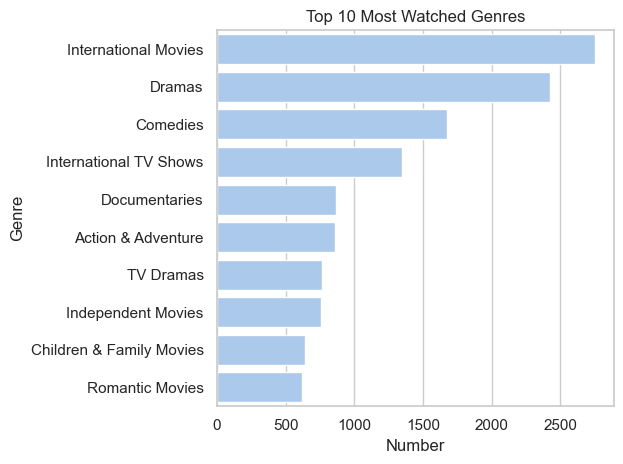

In [24]:
sns.barplot(data=top_genres, x='count', y='genre')
plt.title('Top 10 Most Watched Genres')
plt.xlabel('Number')
plt.ylabel('Genre')
plt.tight_layout()
plt.savefig("../visuals/top_genres.png")
plt.show()